In [1]:
import logging
import os

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from skimage import img_as_ubyte, color, feature, exposure
from sklearn.model_selection import train_test_split
from torch.utils import data
from torchvision import datasets
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

    
import torch.optim as optim

from torch import nn
import torch.nn.functional as F

In [2]:


# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# img = cv2.imread('WIN_20201209_17_25_54_Pro.jpg')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# for (x,y,w,h) in faces:
#     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
#     roi_gray = gray[y:y+h, x:x+w]
#     roi_color = img[y:y+h, x:x+w]

# cv2.imshow('img',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [2]:
class HOG:
    def __init__(self, orientations, pix_per_cell, cells_per_block, multichannel):
        self.orientations = orientations
        self.pix_per_cell = pix_per_cell
        self.cells_per_block = cells_per_block
        self.multichannel = multichannel

    def fit(self, X):
        return self

    def transform(self, X):
        hog_arr = list()

        logger.info(f"Beginning HOG transformations for {len(X)} images")
        for i in tqdm(range(len(X))):
            img = img_as_ubyte(color.rgb2gray(X[i]))
            HOG_des = feature.hog(
                img,
                orientations=self.orientations,
                pixels_per_cell=self.pix_per_cell,
                cells_per_block=self.cells_per_block,
                feature_vector=True,
                multichannel=False
            )
            hog_arr.append(HOG_des)
        return hog_arr

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def __call__(self, x):
        HOG_des = feature.hog(
            x,
            orientations=self.orientations,
            pixels_per_cell=self.pix_per_cell,
            cells_per_block=self.cells_per_block,
            feature_vector=True,
            multichannel=True
        )
        return HOG_des

In [137]:
path = '../cw_dataset'

transform_dict = {
    # the training transforms contain data augmentation
    "train_hog": transforms.Compose(
        [
#         transforms.RandomPerspective(distortion_scale=0.25),
        transforms.ColorJitter(0.50, 0.50, 0.05, 0.05),
        transforms.GaussianBlur(7, (0.01, 2)),
        transforms.RandomGrayscale(p=0.5),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(15, interpolation=transforms.functional.InterpolationMode('nearest')),
        transforms.RandomAffine(15, scale=(0.75, 1.25)),
        transforms.ToTensor(),
        transforms.RandomErasing(),
        ]
    ),
    "val_hog": transforms.Compose([transforms.ToTensor()]),
    "train_cnn": transforms.Compose(
        [
#         transforms.RandomPerspective(distortion_scale=0.25),
        transforms.ColorJitter(0.50, 0.50, 0.05, 0.05),
        transforms.GaussianBlur(3, (0.01, 1)),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(15, interpolation=transforms.functional.InterpolationMode('nearest')),
        transforms.RandomAffine(30, scale=(0.7, 1.3)),
        transforms.ToTensor(),
        transforms.RandomErasing(),

        ]
    ),
}
ds_transform = datasets.ImageFolder(path + "/" + 'train', transform=transform_dict['train_cnn'])
ds_no_trans = datasets.ImageFolder(path + "/" + 'train')

In [138]:
transform_images = list()
transform_labels = list()

for img, label in ds_transform:
    img = img.permute(1, 2, 0).numpy()
    label = int(label)
    transform_images.append(img)
    transform_labels.append(label)

In [139]:
images = list()
labels = list()
for img, label in ds_no_trans:
    label = int(label)
    images.append(img)
    labels.append(label)

In [244]:
import random
random_idx = random.randint(0, len(images))

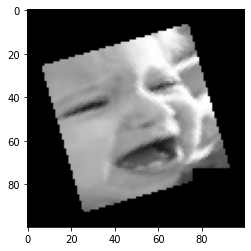

In [245]:
trans_img = transform_images[random_idx]
ctrl_img = images[random_idx]
plt.imshow(trans_img)

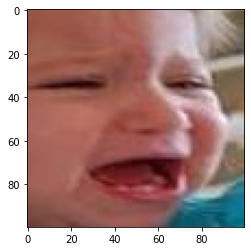

In [246]:
plt.imshow(ctrl_img)

In [84]:
HOG_des = feature.hog(
    img,
    orientations=16,
    pixels_per_cell=(8,8),
    cells_per_block=(1,1),
    feature_vector=True,
    multichannel=True
)

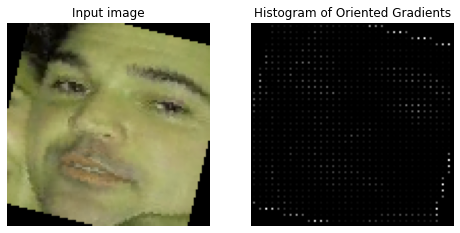

In [89]:
fd, hog_image = feature.hog(img, orientations=16, pixels_per_cell=(3, 3),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [9]:
def load_data(path, subset, method, mode="sklearn"):
    if not os.path.exists(path):
        logger.info("Please download training/testing data to CW_Dataset directory")
        return None
    
    key = subset + "_" + method
    
    transform_dict = {
        # the training transforms contain data augmentation
        "train_hog": transforms.Compose(
            [
                transforms.RandomPerspective(distortion_scale=0.15),
                transforms.ColorJitter(0.25, 0.15, 0.05, 0.05),
                transforms.GaussianBlur(7, (0.01, 0.5)),
                transforms.RandomGrayscale(p=0.5),
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(100, (0.85, 1)),
                HOG(orientations=8, pix_per_cell=(4, 4), cells_per_block=(1,1), multichannel=True)
            ]
        ),
        "val_hog": transforms.Compose([transforms.ToTensor()]),
        "train_cnn": transforms.Compose(
            [
                transforms.RandomPerspective(distortion_scale=0.10),
                transforms.ColorJitter(0.50, 0.50, 0.05, 0.05),
                transforms.GaussianBlur(7, (0.01, 1)),
                transforms.RandomGrayscale(p=0.5),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(100, (0.85, 1)),
            ]
        ),
        "test_hog": transforms.Compose([transforms.ToTensor()]),
    }

    dataset = datasets.ImageFolder(path + "/" + subset, transform=transform_dict[key])

    if mode == "sklearn":
        images = list()
        labels = list()

        for img, label in dataset:
            img = img.permute(1, 2, 0).numpy()
            label = int(label)
            images.append(img)
            labels.append(label)
        logger.info(f"Successfully loaded {len(images)} images")
        return images, labels
    else:
        return data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)


class EmotionRecMLP(nn.Module):

    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, num_outputs):
        super(EmotionRecMLP, self).__init__()

        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_size_3 = hidden_size_3
        self.num_outputs = num_outputs
        self.dropout = nn.Dropout(p=0.1)

        self.fc1 = nn.Linear(self.input_size, self.hidden_size_1)
        self.fc2 = nn.Linear(self.hidden_size_1, self.hidden_size_2)
        self.fc3 = nn.Linear(self.hidden_size_2, self.hidden_size_3)
        self.fc4 = nn.Linear(self.hidden_size_3, self.num_outputs)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [10]:
dl = load_data("../../CW_Dataset", "train", method='cnn', mode='pytorch')

INFO:__main__:Please download training/testing data to CW_Dataset directory


In [11]:
next(iter(dl))[0]

TypeError: 'NoneType' object is not iterable

In [ ]:
# subset = 'train'
# path = "../../CW_Dataset"
# transform_dict = {
#     # the training transforms contain data augmentation
#     "train": transforms.Compose(
#         [
#             transforms.RandomPerspective(distortion_scale=0.15),
#             transforms.ColorJitter(0.25, 0.15, 0.05, 0.05),
#             transforms.GaussianBlur(7, (0.01, 0.5)),
#             transforms.RandomGrayscale(p=0.5),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomResizedCrop(100, (0.85, 1)),
#             transforms.ToTensor(),
#         ]
#     ),
#     "val": transforms.Compose([transforms.ToTensor()]),
#     "test": transforms.Compose([transforms.ToTensor()]),
# }

# dataset = datasets.ImageFolder(path + "/" + subset, transform=transform_dict[subset])
# dl = data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=2)

In [12]:
def imshow(img):   # Unnormalize: back to range [0, 1] just for showing the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))     # Reshape: C, H, W -> H, W, C
    plt.show()

images, labels = next(iter(dl))
imshow(torchvision.utils.make_grid(images))

TypeError: 'NoneType' object is not iterable

In [14]:
plt.imshow(X_train[20])

NameError: name 'X_train' is not defined

In [15]:
plt.imshow(X_train[20])

NameError: name 'X_train' is not defined

In [117]:
hog = HOG(orientations=8, pix_per_cell=(3, 3), cells_per_block=(1,1), multichannel=True)

In [118]:
hog_arr = hog.fit_transform(X_train)

INFO:__main__:Beginning HOG transformations for 9816 images
100%|██████████| 9816/9816 [03:34<00:00, 45.68it/s]


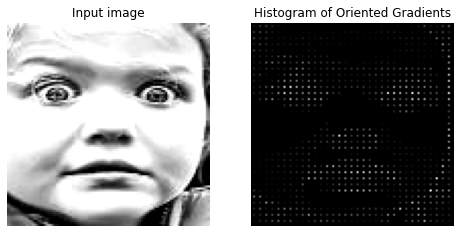

In [116]:
# image = X_train[0]

# fd, hog_image = feature.hog(
#                 image,
#                 orientations=8,
#                 pixels_per_cell=(3,3),
#                 cells_per_block=(1,1),
#                 feature_vector=False,
#                 visualize=True,
#                 multichannel=True
#             )

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# ax1.axis('off')
# ax1.imshow(image, cmap=plt.cm.gray)
# ax1.set_title('Input image')

# # Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# ax2.axis('off')
# ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
# ax2.set_title('Histogram of Oriented Gradients')
# plt.show()

In [119]:
tensor_X = torch.tensor(hog_arr).float()

In [120]:
tensor_y = torch.tensor(y_train)

In [125]:
my_dataset = data.TensorDataset(tensor_X, tensor_y)
my_dataloader = data.DataLoader(my_dataset, batch_size=2)

In [126]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [127]:
hog_arr[0].shape

(8712,)

In [128]:
import time


t0 = time.time()

net = EmotionRecMLP(8712, 2500, 1200, 500, 7)
net = net.float()
net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(4):  # loop over the training set two times

    running_loss = 0.0
    for i, data_batch in enumerate(my_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data_batch[0].to(device), data_batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics (loss.item() returns the mean loss in the mini-batch)
        running_loss += loss.item()
        if i % 32 == 0:
            logger.info('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 32))
            running_loss = 0.0

print('Finished Training: total time in seconds =', time.time() - t0)

INFO:__main__:[1,     1] loss: 0.06129
INFO:__main__:[1,    33] loss: 0.46907
INFO:__main__:[1,    65] loss: 0.00000
INFO:__main__:[1,    97] loss: 0.00000
INFO:__main__:[1,   129] loss: 0.00000
INFO:__main__:[1,   161] loss: 0.00000
INFO:__main__:[1,   193] loss: 0.00000
INFO:__main__:[1,   225] loss: 0.00000
INFO:__main__:[1,   257] loss: 0.00000
INFO:__main__:[1,   289] loss: 0.00000
INFO:__main__:[1,   321] loss: 0.00000
INFO:__main__:[1,   353] loss: 0.00000
INFO:__main__:[1,   385] loss: 0.00000
INFO:__main__:[1,   417] loss: 0.00000
INFO:__main__:[1,   449] loss: 0.00000
INFO:__main__:[1,   481] loss: 0.00000
INFO:__main__:[1,   513] loss: 0.00000
INFO:__main__:[1,   545] loss: 2.19479
INFO:__main__:[1,   577] loss: 0.00000
INFO:__main__:[1,   609] loss: 0.00000
INFO:__main__:[1,   641] loss: 2.44549
INFO:__main__:[1,   673] loss: 0.06865
INFO:__main__:[1,   705] loss: 0.00000
INFO:__main__:[1,   737] loss: 0.00000
INFO:__main__:[1,   769] loss: 0.00000
INFO:__main__:[1,   801] 

Finished Training: total time in seconds = 90.0901050567627


In [129]:
model_path = "..\\..\\Models"
model_name = f"hog_mlp_{time.strftime('%Y-%m-%d %H-%S')}.pth"

model_file_name =  model_path + '/' + model_name
torch.save(net.state_dict(),model_file_name)

In [130]:
net = EmotionRecMLP(8712, 2500, 1200, 500, 7)
net.load_state_dict(torch.load(model_file_name))

<All keys matched successfully>

In [131]:
X_val, y_val = load_data("../../CW_Dataset", "val", mode='sklearn')

INFO:__main__:Successfully loaded 2455 images


In [132]:
hog_arr_val = hog.fit_transform(X_val)

INFO:__main__:Beginning HOG transformations for 2455 images
100%|██████████| 2455/2455 [00:54<00:00, 44.86it/s]


In [133]:
tensor_X_val = torch.tensor(hog_arr_val).float()

In [134]:
tensor_y_val = torch.tensor(y_val)

In [135]:
val_dataset = data.TensorDataset(tensor_X_val, tensor_y_val)
val_dataloader = data.DataLoader(val_dataset, batch_size=2, shuffle=True)

In [136]:
valloader_iter = iter(val_dataloader)
images, labels = valloader_iter.next()

In [137]:
outputs = net(images)

In [138]:
_, predicted = torch.max(outputs, 1)

In [139]:
predicted

tensor([6, 6])

In [140]:
labels

tensor([6, 6])

In [141]:
# Estimate average accuracy
correct = 0
total = 0
with torch.no_grad():             # Avoid backprop at test 
    for data_batch in val_dataloader:
        images, labels = data_batch
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the validation images: {100 * correct / total}%")

Accuracy of the network on the validation images: 20.570264765784113%


In [82]:
1/7

0.14285714285714285

In [203]:
X, y = load_data("../../CW_Dataset", "train")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)


INFO:__main__:Loading 12271 images
INFO:__main__:Successfully loaded 12271 images
